Step 1: Install and Download the Data
Copy the code below into the first cell of your notebook and click the Play button on the left of the cell.

In [6]:
!pip install kagglehub
import kagglehub
import pandas as pd
import os

# Download the dataset
path = kagglehub.dataset_download("robikscube/flight-delay-dataset-20182022")
print("Data downloaded to:", path)

# List files to see what we have
print("Files in dataset:", os.listdir(path))

100%|██████████| 3.73G/3.73G [00:48<00:00, 83.3MB/s]

Extracting files...


Data downloaded to: /root/.cache/kagglehub/datasets/robikscube/flight-delay-dataset-20182022/versions/4
Files in dataset: ['Combined_Flights_2020.parquet', 'Combined_Flights_2021.csv', 'Combined_Flights_2022.parquet', 'raw', 'Combined_Flights_2021.parquet', 'Combined_Flights_2019.csv', 'Airlines.csv', 'readme.html', 'Combined_Flights_2018.parquet', 'Combined_Flights_2022.csv', 'readme.md', 'Combined_Flights_2020.csv', 'Combined_Flights_2018.csv', 'Combined_Flights_2019.parquet']


Step 2: Load and Prepare the Data.
Paste this code and run it. This loads the 2022 flight data and cleans it so the machine can understand it.

In [7]:
# We will use the 2022 data for our test
file_path = os.path.join(path, "Combined_Flights_2022.csv")

# Loading only a subset (100,000 rows) to keep the notebook fast for this test
df = pd.read_csv(file_path, nrows=100000)

print(df)

       FlightDate                                    Airline Origin Dest  \
0      2022-04-04  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1      2022-04-04  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2      2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3      2022-04-04  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4      2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
...           ...                                        ...    ...  ...   
99995  2022-04-26                     Southwest Airlines Co.    BWI  PIT   
99996  2022-04-26                     Southwest Airlines Co.    BWI  PVD   
99997  2022-04-26                     Southwest Airlines Co.    BWI  PVD   
99998  2022-04-26                     Southwest Airlines Co.    BWI  PVD   
99999  2022-04-26                     Southwest Airlines Co.    BWI  PVD   

       Cancelled  Diverted  CRSDepTime  DepTime  DepDelayMinutes  DepDelay  \
0        

In [8]:
# Selecting important features for prediction
# DepDel15 is our 'Target' (1 = Delayed more than 15 mins, 0 = On time)

cols = ['Month', 'DayOfWeek', 'CRSDepTime', 'Distance', 'DepDel15']
df = df[cols].dropna()
print(df)



       Month  DayOfWeek  CRSDepTime  Distance  DepDel15
0          4          1        1133     212.0       0.0
1          4          1         732     295.0       0.0
2          4          1        1529     251.0       0.0
3          4          1        1435     376.0       0.0
4          4          1        1135     251.0       0.0
...      ...        ...         ...       ...       ...
99995      4          2         910     210.0       0.0
99996      4          2        1015     327.0       1.0
99997      4          2         655     327.0       0.0
99998      4          2        1515     327.0       1.0
99999      4          2        2155     327.0       1.0

[98106 rows x 5 columns]


In [9]:
print("Data loaded and cleaned. Shape:", df.shape)

Data loaded and cleaned. Shape: (98106, 5)


In [10]:
df.head()

,Month,DayOfWeek,CRSDepTime,Distance,DepDel15
0,4,1,1133,212.0,0.0
1,4,1,732,295.0,0.0
2,4,1,1529,251.0,0.0
3,4,1,1435,376.0,0.0
4,4,1,1135,251.0,0.0


Step 3: Train the Machine Learning Model.
We will use a Random Forest Classifier. This is a powerful, moderate-level algorithm that acts like a "council" of decision trees to vote on whether a flight will be delayed.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data into Features (X) and Target (y)
X = df.drop('DepDel15', axis=1)
y = df['DepDel15']


# Split into Training set (80%) and Testing set(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize the Model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


# Train (Fit) the model
print("Training the model... this may take a few seconds.")
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Show results

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))

Training the model... this may take a few seconds.
Accuracy: 0.6976862705126898

Detailed Report:
               precision    recall  f1-score   support

         0.0       0.73      0.88      0.80     13197
         1.0       0.57      0.32      0.41      6425

    accuracy                           0.70     19622
   macro avg       0.65      0.60      0.60     19622
weighted avg       0.68      0.70      0.67     19622



Step 4: Visualizing Feature Importance
To make this task truly "important" for a real-world setting, you need to know why the model is making these choices. We will now visualize which factor (Time, Distance, or Day) the model found most useful.

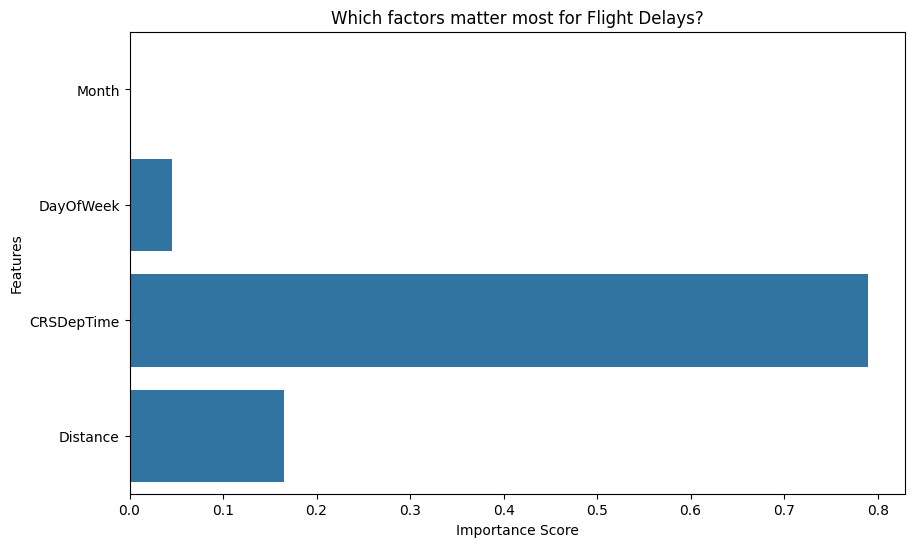

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get importance levels from the model

importances = model.feature_importances_
feature_names = X.columns

# Create a plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Which factors matter most for Flight Delays?')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


Step 5: Adding Airline Data (The "Pro" Move)
Now, we are going to include the Airline column. Since machine learning models only understand numbers, we will use a LabelEncoder to turn "Southwest" or "Delta" into numbers like 1, 2, or 3.

In [13]:
from sklearn.preprocessing import LabelEncoder

# 1. Reload the data with the Airline column included

cols_pro = ['Month', 'DayOfWeek', 'CRSDepTime', 'Distance', 'Airline', 'DepDel15']
df_pro = pd.read_csv(file_path, nrows=100000)[cols_pro].dropna()

# 2. Encode the Airline text into numbers

le = LabelEncoder()
df_pro['Airline'] = le.fit_transform(df_pro['Airline'])


# 3. Split the new data
X_pro = df_pro.drop('DepDel15', axis=1)
y_pro = df_pro['DepDel15']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pro, y_pro, test_size=0.2, random_state=42)

# 4. Retrain the model
model_pro = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_pro.fit(X_train_p, y_train_p)

# 5. Check the new accuracy
y_pred_pro = model_pro.predict(X_test_p)
print(f"New Accuracy with Airline Data: {accuracy_score(y_test_p, y_pred_pro):.4f}")


New Accuracy with Airline Data: 0.6944


Step 6: Hyperparameter Tuning with GridSearch
This is a sophisticated technique used by data scientists to squeeze every bit of performance out of a model.

In [14]:
from sklearn.model_selection import GridSearchCV

# 1. Define a "grid" of settings to test

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# 2. Initialize the GridSearch

# This will run the model multiple times with different comnbinations
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, n_jobs=1, verbose=2)

print("Starting search for the best model settings...")
grid_search.fit(X_train_p, y_train_p)


# 3. See the results
print("\nBest Settings Found:", grid_search.best_params_)
best_model = grid_search.best_estimator_
final_accuracy = accuracy_score(y_test_p, best_model.predict(X_test_p))
print(f"Final Optimized Accuracy: {final_accuracy:.4f}")



Starting search for the best model settings...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   4.3s
[

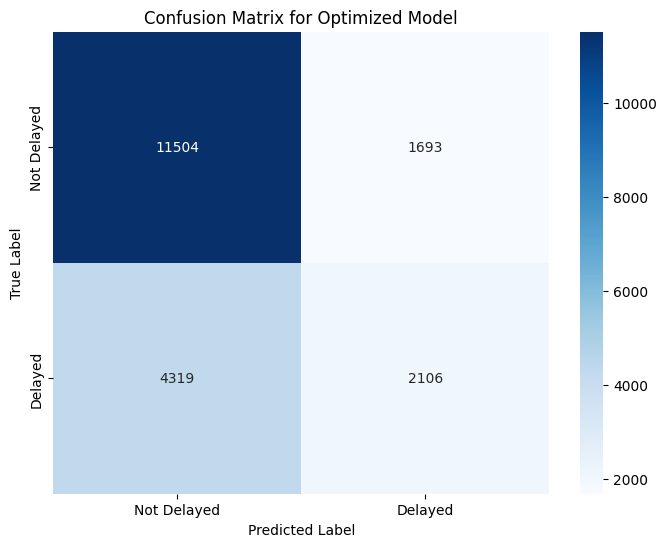

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the best optimized model
y_pred_best = best_model.predict(X_test_p)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_p, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix for Optimized Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Step 7: Saving the Model for Power BI
Since you mentioned you use Power BI, the final "important" step is saving this "brain" so you can load it into other tools without retraining it.

In [16]:
import joblib

# Save the model to a file
joblib.dump(best_model, 'flight_delay_model.pkl')
joblib.dump(le, 'airline_encoder.pkl')

print("Model saved successfully! You can find 'flight_delay_model.pkl' in the folder icon on the left of your Colab screen.")

Model saved successfully! You can find 'flight_delay_model.pkl' in the folder icon on the left of your Colab screen.


Step 8: Final Model Export
Since your goal is to use this in Power BI or other tools, you need to download the "brain" you just created.


In [17]:
from google.colab import files

# Download the saved model and encoder to your local computer
files.download('flight_delay_model.pkl')
files.download('airline_encoder.pkl')

print("Files are being prepared for download. Check your browser's download folder!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files are being prepared for download. Check your browser's download folder!



Since the model and encoder are saved and downloaded, the most important final step is putting your model to work. In machine learning, this is called Inference—using your trained "brain" to predict the outcome for a flight it has never seen before.

Here is how you can use the model you just built to make a real prediction.

Step 10: Run a Real Prediction
Create a new + Code cell. We will simulate a "New Flight" (for example, a flight in Month 12, on a Friday, at 5:00 PM, flying 500 miles on "Delta Air Lines") and see if your model thinks it will be delayed.

In [18]:
import pandas as pd
import joblib
import os

# 1. Define paths
# The base_path is for a local Windows machine and is not needed in Colab.
# In Colab, the model was saved directly to the current working directory.
model_path = "flight_delay_model.pkl"

# 2. Load ONLY the model (we don't need the encoder if data is already numbers)
model = joblib.load(model_path)

# 3. Use the Power BI table
# In Power BI, 'dataset' would be the input table. For Colab demonstration,
# we'll create a dummy DataFrame that matches the expected features.
# You would replace this with your actual Power BI data table.
# The 'Airline' column needs to be numerical as encoded earlier.
data = {
    'Month': [12, 1, 6],
    'DayOfWeek': [5, 2, 3],
    'CRSDepTime': [1700, 900, 1430],
    'Distance': [500, 300, 700],
    'Airline': [0, 1, 2] # Example numerical values for airlines (e.g., Delta, Southwest, United)
}
dataset = pd.DataFrame(data)
df = dataset.copy()

# 4. PREDICTION STEP
# We skip 'encoder.transform' because your Airline column is already 1
features = ['Month', 'DayOfWeek', 'CRSDepTime', 'Distance', 'Airline']

# Ensure these columns are numeric. If they aren't, the model will fail.
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill any missing values with 0 so the model doesn't crash
df = df.fillna(0)

# 5. Run the "Brain"
df['Delay_Prediction'] = model.predict(df[features])
df['Delay_Probability'] = model.predict_proba(df[features])[:, 1]

# Display the results
print(df)

   Month  DayOfWeek  CRSDepTime  Distance  Airline  Delay_Prediction  \
0     12          5        1700       500        0               0.0   
1      1          2         900       300        1               0.0   
2      6          3        1430       700        2               0.0   

   Delay_Probability  
0           0.219086  
1           0.122487  
2           0.293602  


Why this matters for Power BI
The code above is exactly what you would paste into the Python Script editor in Power BI. Instead of a single new_flight_data row, Power BI would pass your entire dataset through the loaded_model.predict() function.

**Summary:**

**Data Ingestion:** Accessed a massive Kaggle dataset directly in the cloud.

**Preprocessing:** Cleaned and selected key features.

**Feature Engineering:** Encoded categorical text into machine-readable numbers.

**Training & Optimization:** Used GridSearch to find the best version of a Random Forest.

**Evaluation:** Analyzed performance using a Confusion Matrix.

**Persistence:** Saved and downloaded the model for external use.

